# Gender Inequality

## Getting Started

### Loading Countries + Regions

In [2]:
import wbdata
import pandas as pd

# Fetch all countries from the World Bank API and create a DataFrame in one step
countries_data = wbdata.get_countries()
#convert into a dataframe
country_df = pd.DataFrame([{
    'CountryID': country['id'],
    'Region Name': country['region']['value'],
    'Country Name': country['name'],
    'Country Region ID': country['region']['id'],
    'Adminergion ID': country['adminregion']['id'],
    'Income Level': country['incomeLevel']['value'],
    'Lending Type': country['lendingType']['value']}
    for country in countries_data if country['region']['value'] != "Aggregates"
])

country_df

,CountryID,Region Name,Country Name,Country Region ID,Adminergion ID,Income Level,Lending Type
0,ABW,Latin America & Caribbean,Aruba,LCN,,High income,Not classified
1,AFG,South Asia,Afghanistan,SAS,SAS,Low income,IDA
2,AGO,Sub-Saharan Africa,Angola,SSF,SSA,Lower middle income,IBRD
3,ALB,Europe & Central Asia,Albania,ECS,ECA,Upper middle income,IBRD
4,AND,Europe & Central Asia,Andorra,ECS,,High income,Not classified
...,...,...,...,...,...,...,...
212,XKX,Europe & Central Asia,Kosovo,ECS,ECA,Upper middle income,IDA
213,YEM,Middle East & North Africa,"Yemen, Rep.",MEA,MNA,Low income,IDA
214,ZAF,Sub-Saharan Africa,South Africa,SSF,SSA,Upper middle income,IBRD
215,ZMB,Sub-Saharan Africa,Zambia,SSF,SSA,Lower middle income,IDA


###

In [ ]:
import wbdata
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from requests.exceptions import ConnectionError
from scipy.stats import ttest_rel

sns.set_style('whitegrid')
sns.set_context('talk')

def safe_get_data(indicator, countries, attempts=3, delay=5):
    """
    Safely fetch data from the World Bank API with retries.
    If a ConnectionError occurs, waits `delay` seconds and retries up to `attempts` times.
    """
    for i in range(attempts):
        try:
            data = wbdata.get_data(indicator, country=countries)
            return data
        except ConnectionError:
            print(f"Connection error for indicator {indicator}, attempt {i+1}/{attempts}. Retrying in {delay} seconds...")
            time.sleep(delay)
    print(f"Failed to fetch {indicator} after {attempts} attempts.")
    return []

# Define pairs
pairs = [
    ("SH.STA.SUIC.MA.P5", "SH.STA.SUIC.FE.P5", "Suicide mortality rate (per 100,000)"),
    ("VC.IHR.PSRC.MA.P5", "VC.IHR.PSRC.FE.P5", "Intentional homicides (per 100,000)"),
    ("SH.STA.POIS.P5.MA", "SH.STA.POIS.P5.FE", "Unintentional poisoning mortality (per 100,000)"),
    ("SH.STA.AIRP.MA.P5", "SH.STA.AIRP.FE.P5", "Air pollution mortality (per 100,000)"),
    ("SP.DYN.AMRT.MA", "SP.DYN.AMRT.FE", "Adult mortality rate (per 1,000)"),
    ("SP.DYN.IMRT.MA.IN", "SP.DYN.IMRT.FE.IN", "Infant mortality rate (per 1,000 live births)"),
    ("SH.DYN.MORT.MA", "SH.DYN.MORT.FE", "Under-5 mortality rate (per 1,000 live births)"),
    ("SH.CON.1524.MA.ZS","SH.CON.1524.FE.ZS","Condom use, population ages 15-24"),
    ("SP.DYN.TO65.MA.ZS","SP.DYN.TO65.FE.ZS","Survival to age 65 (% of cohort)"),
    ("SH.ALC.PCAP.MA.LI","SH.ALC.PCAP.FE.LI","Total alcohol consumption per capita (liters, 15+)"),
    ("SE.PRM.CMPL.MA.ZS","SE.PRM.CMPL.FE.ZS","Gross graduation ratio, primary (%)"),
    ("SG.AGE.RTRE.FL.MA","SG.AGE.RTRE.FL.FE","Retirement age with full benefits"),
    ("SP.DYN.LE60.MA.IN","SP.DYN.LE60.FE.IN","Life expectancy at age 60 (years)"),
    ("SH.STA.OB18.MA.ZS","SH.STA.OB18.FE.ZS","Prevalence of obesity (% age 18+)"),
    ("SH.PRV.SMOK.MA","SH.PRV.SMOK.FE","Prevalence of tobacco use (%)"),
    ("UIS.LP.AG15T24.M","UIS.LP.AG15T24.F","Youth illiterate population, 15-24"),
    ("SP.POP.TOTL.MA.ZS","SP.POP.TOTL.FE.ZS","Population (% of total)")
]

# Entities to plot together:
entities = [
    ("US", "United States"),
    ("AR", "Argentina"),
    ("GB", "United Kingdom"),
    ("WLD", "World")
]

# Create a single figure for all pairs
fig, axes = plt.subplots(len(pairs), 2, figsize=(20, 4*len(pairs)))
if len(pairs) == 1:
    axes = [axes]  # Ensure iterable if only one pair
fig.suptitle("Male vs. Female Indicators: All Entities Overlaid", fontsize=16, fontweight='bold', y=1.02)

# Assign colors for each entity for consistency
entity_names = [e[1] for e in entities]
palette = sns.color_palette('husl', n_colors=len(entities))
entity_color_map = dict(zip(entity_names, palette))

for i, (male_indicator, female_indicator, title) in enumerate(pairs):
    ax_line, ax_diff = axes[i]

    # We'll store data for all entities in a dict
    # Key: entity_name, Value: (male_series, female_series)
    entity_data = {}

    for entity_code, entity_name in entities:
        data_m = safe_get_data(male_indicator, entity_code, attempts=3, delay=5)
        df_m = pd.DataFrame(data_m)

        data_f = safe_get_data(female_indicator, entity_code, attempts=3, delay=5)
        df_f = pd.DataFrame(data_f)

        if df_m.empty or df_f.empty:
            # No data for this entity
            continue

        df_m['date'] = pd.to_numeric(df_m['date'], errors='coerce')
        df_f['date'] = pd.to_numeric(df_f['date'], errors='coerce')
        df_m = df_m[['date', 'value']].dropna()
        df_f = df_f[['date', 'value']].dropna()

        common_years = set(df_m['date']).intersection(set(df_f['date']))
        if not common_years:
            # No overlap in years for this entity
            continue

        df_m = df_m[df_m['date'].isin(common_years)].set_index('date').sort_index()
        df_f = df_f[df_f['date'].isin(common_years)].set_index('date').sort_index()

        male_values = df_m['value']
        female_values = df_f['value']

        if len(male_values) < 2 or len(female_values) < 2:
            # Not enough data points to run a test
            # Still plot what we have
            entity_data[entity_name] = (male_values, female_values, None)
        else:
            # Paired t-test
            stat, pvalue = ttest_rel(male_values, female_values, nan_policy='omit')
            entity_data[entity_name] = (male_values, female_values, pvalue)

    # Now plot all entities together
    if not entity_data:
        # No data for any entity
        ax_line.set_title(f"{title}\nNo data for any entity", fontweight='bold')
        ax_line.text(0.5, 0.5, "No data", ha='center', va='center')
        ax_line.axis('on')
        ax_diff.axis('off')
        continue

    # Plot male/female for all entities on the left subplot
    for entity_name, (male_values, female_values, pvalue) in entity_data.items():
        color = entity_color_map[entity_name]
        # Plot male line
        ax_line.plot(male_values.index, male_values, label=f'{entity_name} Male', color=color, marker='o', linestyle='-')
        # Plot female line (use a slightly different style)
        ax_line.plot(female_values.index, female_values, label=f'{entity_name} Female', color=color, marker='^', linestyle='--')

    ax_line.set_title(title, fontweight='bold')
    ax_line.set_xlabel("Year")
    ax_line.set_ylabel("Value")

    # Create a combined legend without duplicates
    handles, labels = ax_line.get_legend_handles_labels()
    unique = dict(zip(labels, handles))
    ax_line.legend(unique.values(), unique.keys(), fontsize=8, frameon=True)

    # Plot difference lines (male - female) for all entities on the right subplot
    for entity_name, (male_values, female_values, pvalue) in entity_data.items():
        if male_values.empty or female_values.empty:
            continue
        difference = male_values - female_values
        color = entity_color_map[entity_name]
        ax_diff.plot(difference.index, difference, color=color, marker='o', label=entity_name)
        # If significant p-value for this entity, annotate near top of plot
        if pvalue is not None and pvalue < 0.05:
            # Place annotation near the last data point
            last_year = difference.index[-1]
            ax_diff.text(last_year, difference.iloc[-1],
                         f"* (p={pvalue:.3g})",
                         fontsize=10, color='green', ha='center', va='bottom')

    ax_diff.axhline(y=0, color='black', linestyle='--')
    ax_diff.set_title(f"{title}\n(Male - Female)", fontweight='bold')
    ax_diff.set_xlabel("Year")
    ax_diff.set_ylabel("Difference")

    handles_diff, labels_diff = ax_diff.get_legend_handles_labels()
    unique_diff = dict(zip(labels_diff, handles_diff))
    ax_diff.legend(unique_diff.values(), unique_diff.keys(), fontsize=8, frameon=True)

plt.tight_layout(rect=[0,0,1,0.98])
plt.show()


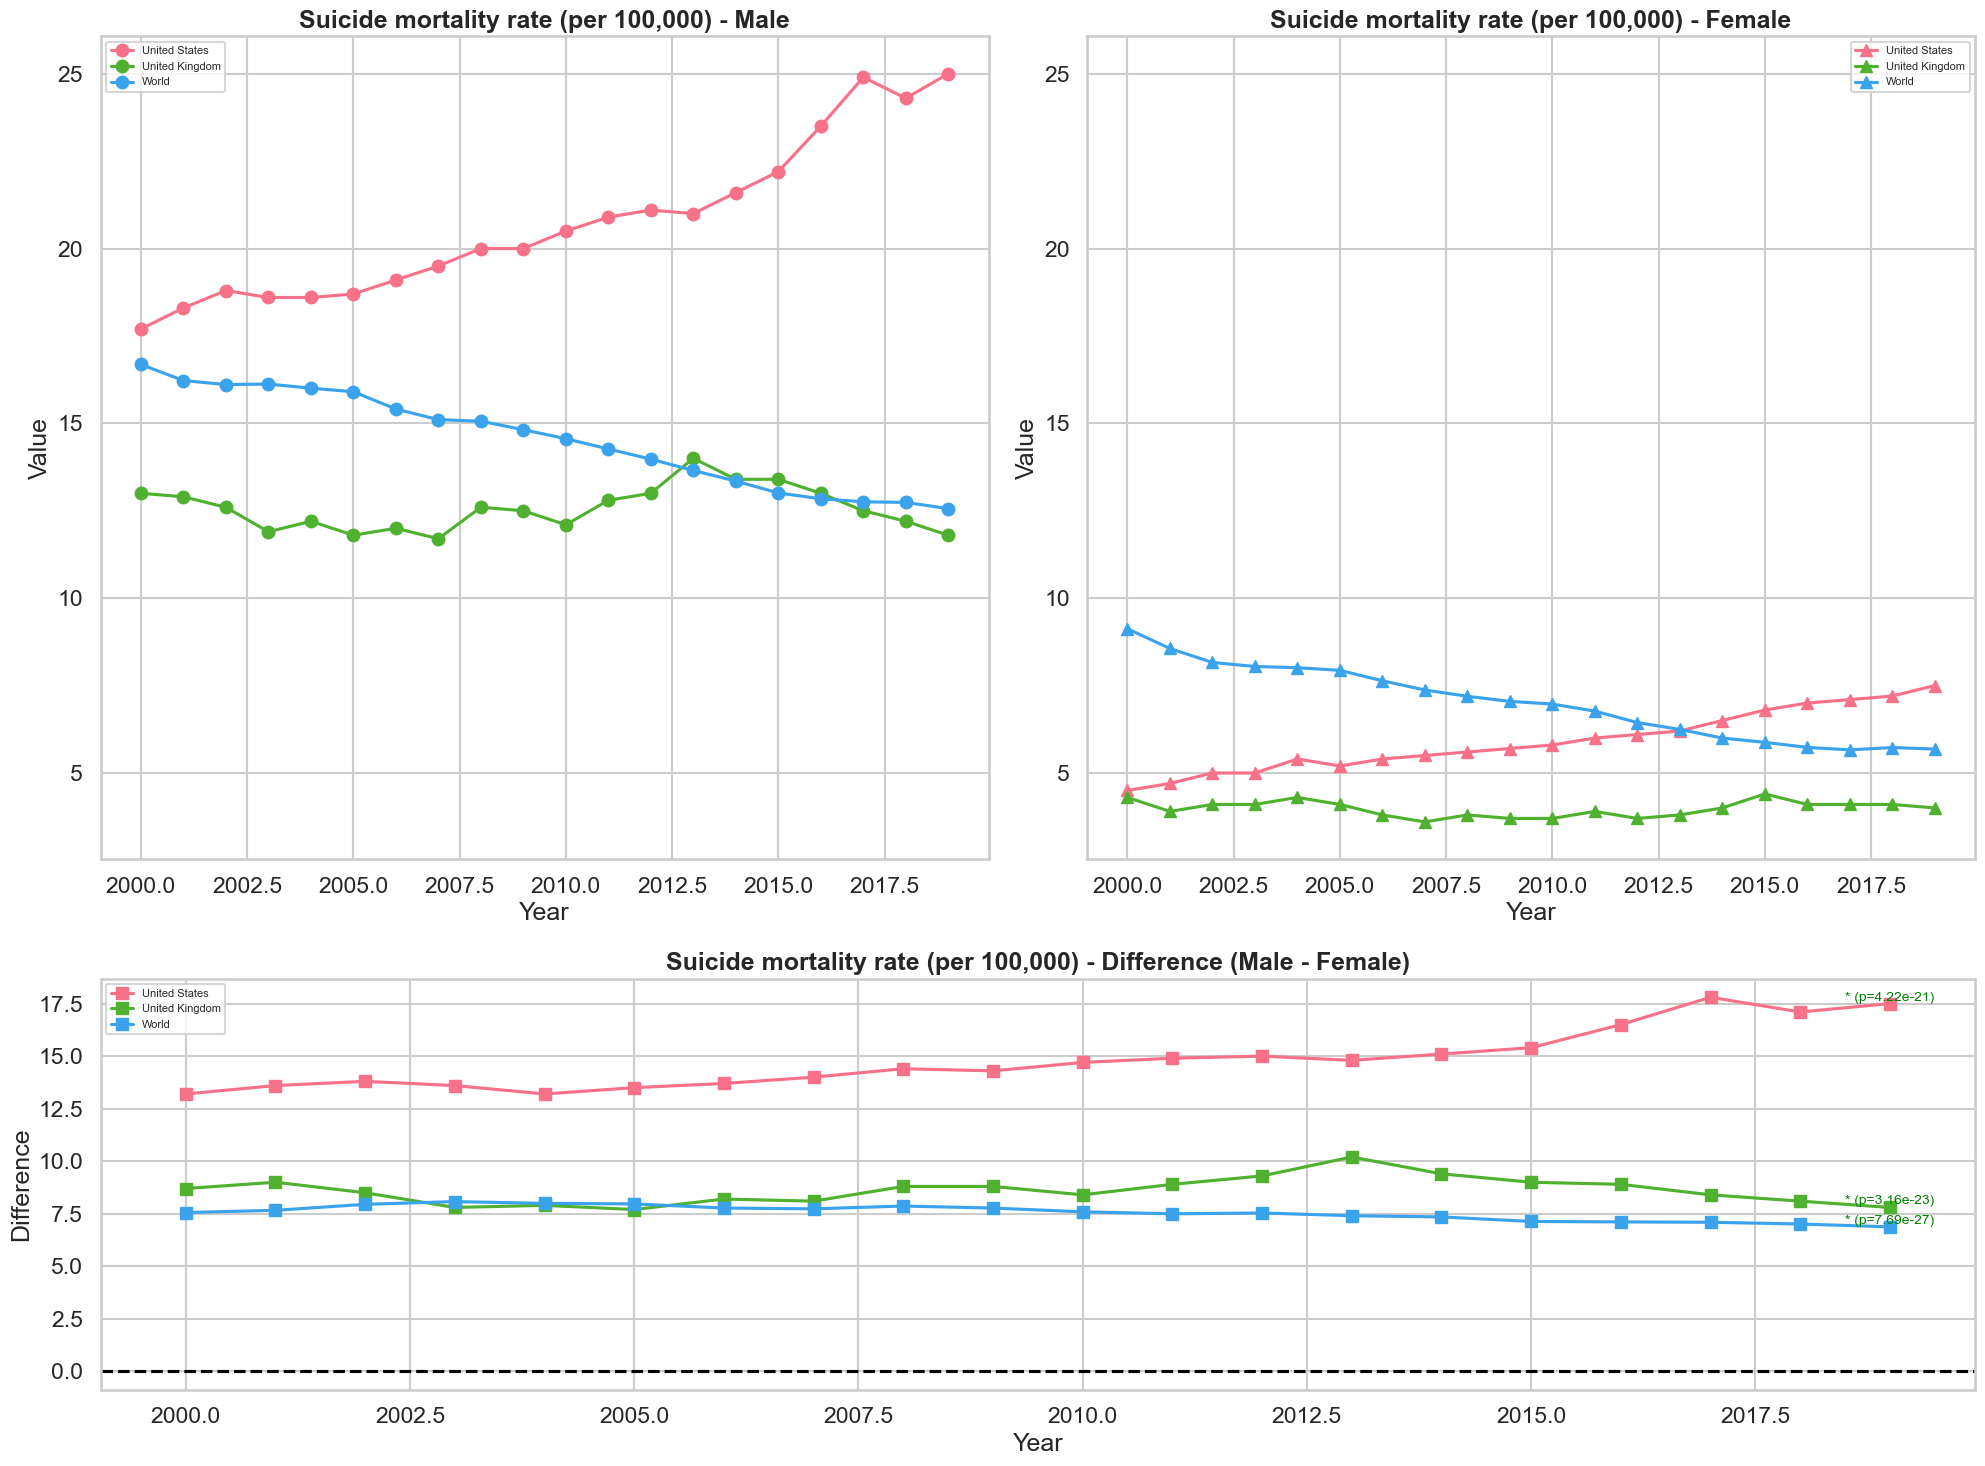


=== United States ===
Statistical Insights for Suicide mortality rate (per 100,000):

Basic Statistics:
- Male: mean=20.71 (±2.20)
- Female: mean=5.91 (±0.85)

Differences:
- Absolute difference: 14.81
- Relative difference: 252.7%

Trends:
- Male: 0.365 per year (p=0.000)
- Female: 0.146 per year (p=0.000)

Statistical Tests:
- Paired t-test: p=0.000
- Mann-Whitney U test: p=0.000
- Pearson correlation: r=0.976 (p=0.000)
- Spearman correlation: ρ=0.985 (p=0.000)


=== United Kingdom ===
Statistical Insights for Suicide mortality rate (per 100,000):

Basic Statistics:
- Male: mean=12.57 (±0.61)
- Female: mean=3.97 (±0.22)

Differences:
- Absolute difference: 8.60
- Relative difference: 217.1%

Trends:
- Male: 0.020 per year (p=0.426)
- Female: -0.001 per year (p=0.914)

Statistical Tests:
- Paired t-test: p=0.000
- Mann-Whitney U test: p=0.000
- Pearson correlation: r=0.134 (p=0.574)
- Spearman correlation: ρ=0.159 (p=0.502)


=== World ===
Statistical Insights for Suicide mortality r

In [2]:
import wbdata
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from requests.exceptions import ConnectionError
from scipy.stats import ttest_rel, mannwhitneyu, pearsonr, spearmanr
from scipy import stats
import numpy as np

sns.set_style('whitegrid')
sns.set_context('talk')

def safe_get_data(indicator, countries, attempts=3, delay=5):
    """
    Safely fetch data from the World Bank API with retries.
    """
    for i in range(attempts):
        try:
            data = wbdata.get_data(indicator, country=countries)
            return data
        except ConnectionError:
            print(f"Connection error for indicator {indicator}, attempt {i+1}/{attempts}. Retrying in {delay} seconds...")
            time.sleep(delay)
    print(f"Failed to fetch {indicator} after {attempts} attempts.")
    return []

def calculate_statistics(male_values, female_values):
    """
    Calculate comprehensive statistics for male and female values.
    """
    stats_dict = {
        'male_mean': np.mean(male_values),
        'female_mean': np.mean(female_values),
        'male_median': np.median(male_values),
        'female_median': np.median(female_values),
        'male_std': np.std(male_values),
        'female_std': np.std(female_values),
        'absolute_difference_mean': np.mean(male_values - female_values),
        'relative_difference_mean': np.mean((male_values - female_values) / female_values) * 100,
        'trend_male': stats.linregress(range(len(male_values)), male_values),
        'trend_female': stats.linregress(range(len(female_values)), female_values)
    }

    # Statistical tests
    if len(male_values) >= 2 and len(female_values) >= 2:
        # Paired t-test
        t_stat, t_pval = ttest_rel(male_values, female_values, nan_policy='omit')
        stats_dict['t_test'] = {'statistic': t_stat, 'pvalue': t_pval}

        # Mann-Whitney U test
        try:
            u_stat, u_pval = mannwhitneyu(male_values, female_values, alternative='two-sided')
            stats_dict['mann_whitney'] = {'statistic': u_stat, 'pvalue': u_pval}
        except ValueError:
            stats_dict['mann_whitney'] = None

        # Correlation tests
        pearson_corr, pearson_p = pearsonr(male_values, female_values)
        spearman_corr, spearman_p = spearmanr(male_values, female_values)
        stats_dict['correlations'] = {
            'pearson': {'correlation': pearson_corr, 'pvalue': pearson_p},
            'spearman': {'correlation': spearman_corr, 'pvalue': spearman_p}
        }

    return stats_dict

def generate_insights(stats_dict, title):
    """
    Generate textual insights from statistical results.
    """
    insights = [f"Statistical Insights for {title}:"]

    # Basic statistics
    insights.append(f"\nBasic Statistics:")
    insights.append(f"- Male: mean={stats_dict['male_mean']:.2f} (±{stats_dict['male_std']:.2f})")
    insights.append(f"- Female: mean={stats_dict['female_mean']:.2f} (±{stats_dict['female_std']:.2f})")

    # Differences
    insights.append(f"\nDifferences:")
    insights.append(f"- Absolute difference: {stats_dict['absolute_difference_mean']:.2f}")
    insights.append(f"- Relative difference: {stats_dict['relative_difference_mean']:.1f}%")

    # Trends
    male_trend = stats_dict['trend_male']
    female_trend = stats_dict['trend_female']
    insights.append(f"\nTrends:")
    insights.append(f"- Male: {male_trend.slope:.3f} per year (p={male_trend.pvalue:.3f})")
    insights.append(f"- Female: {female_trend.slope:.3f} per year (p={female_trend.pvalue:.3f})")

    # Statistical tests
    if 't_test' in stats_dict:
        insights.append(f"\nStatistical Tests:")
        t_test = stats_dict['t_test']
        insights.append(f"- Paired t-test: p={t_test['pvalue']:.3f}")

        if stats_dict['mann_whitney']:
            mw_test = stats_dict['mann_whitney']
            insights.append(f"- Mann-Whitney U test: p={mw_test['pvalue']:.3f}")

        correlations = stats_dict['correlations']
        insights.append(f"- Pearson correlation: r={correlations['pearson']['correlation']:.3f} (p={correlations['pearson']['pvalue']:.3f})")
        insights.append(f"- Spearman correlation: ρ={correlations['spearman']['correlation']:.3f} (p={correlations['spearman']['pvalue']:.3f})")

    return '\n'.join(insights)

def analyze_gender_indicators(pairs, entities):
    """
    Analyze and visualize gender differences across multiple indicators and entities.
    """
    for male_indicator, female_indicator, title in pairs:
        # Create figure with three subplots
        fig = plt.figure(figsize=(20, 15))
        gs = fig.add_gridspec(2, 2, height_ratios=[2, 1])
        ax_male = fig.add_subplot(gs[0, 0])
        ax_female = fig.add_subplot(gs[0, 1])
        ax_diff = fig.add_subplot(gs[1, :])

        entity_data = {}
        all_stats = {}

        # Track min and max values for consistent y-axis
        all_values = []

        # Assign colors
        entity_names = [e[1] for e in entities]
        palette = sns.color_palette('husl', n_colors=len(entities))
        entity_color_map = dict(zip(entity_names, palette))

        for entity_code, entity_name in entities:
            # Fetch and process data
            data_m = safe_get_data(male_indicator, entity_code)
            data_f = safe_get_data(female_indicator, entity_code)

            df_m = pd.DataFrame(data_m)
            df_f = pd.DataFrame(data_f)

            if df_m.empty or df_f.empty:
                continue

            # Process data
            for df in [df_m, df_f]:
                df['date'] = pd.to_numeric(df['date'], errors='coerce')

            df_m = df_m[['date', 'value']].dropna()
            df_f = df_f[['date', 'value']].dropna()

            common_years = set(df_m['date']).intersection(set(df_f['date']))
            if not common_years:
                continue

            df_m = df_m[df_m['date'].isin(common_years)].set_index('date').sort_index()
            df_f = df_f[df_f['date'].isin(common_years)].set_index('date').sort_index()

            male_values = df_m['value']
            female_values = df_f['value']

            # Collect all values for y-axis limits
            all_values.extend(male_values)
            all_values.extend(female_values)

            # Calculate statistics
            stats_dict = calculate_statistics(male_values, female_values)
            all_stats[entity_name] = stats_dict
            entity_data[entity_name] = (male_values, female_values)

            # Plot data
            color = entity_color_map[entity_name]

            # Male subplot
            ax_male.plot(male_values.index, male_values,
                         color=color, marker='o', label=entity_name)

            # Female subplot
            ax_female.plot(female_values.index, female_values,
                           color=color, marker='^', label=entity_name)

            # Difference subplot
            difference = male_values - female_values
            ax_diff.plot(difference.index, difference,
                         color=color, marker='s', label=entity_name)

            # Add significance annotations
            if stats_dict['t_test']['pvalue'] < 0.05:
                last_year = difference.index[-1]
                ax_diff.text(last_year, difference.iloc[-1],
                             f"* (p={stats_dict['t_test']['pvalue']:.3g})",
                             fontsize=10, color='green', ha='center', va='bottom')

        # Set consistent y-axis limits for male and female subplots
        if all_values:
            ymin = min(all_values)
            ymax = max(all_values)
            # Add 5% padding to the limits
            padding = (ymax - ymin) * 0.05
            ax_male.set_ylim(ymin - padding, ymax + padding)
            ax_female.set_ylim(ymin - padding, ymax + padding)

        # Configure subplots
        ax_male.set_title(f"{title} - Male", fontweight='bold')
        ax_male.set_xlabel("Year")
        ax_male.set_ylabel("Value")
        ax_male.legend(fontsize=8, frameon=True)

        ax_female.set_title(f"{title} - Female", fontweight='bold')
        ax_female.set_xlabel("Year")
        ax_female.set_ylabel("Value")
        ax_female.legend(fontsize=8, frameon=True)

        ax_diff.axhline(y=0, color='black', linestyle='--')
        ax_diff.set_title(f"{title} - Difference (Male - Female)", fontweight='bold')
        ax_diff.set_xlabel("Year")
        ax_diff.set_ylabel("Difference")
        ax_diff.legend(fontsize=8, frameon=True)

        plt.tight_layout()
        plt.show()

        # Print statistical insights for each entity
        for entity_name, stats_dict in all_stats.items():
            print(f"\n=== {entity_name} ===")
            print(generate_insights(stats_dict, title))
            print("\n" + "="*50)
# Define pairs
pairs = [
      ("SH.STA.SUIC.MA.P5", "SH.STA.SUIC.FE.P5", "Suicide mortality rate (per 100,000)"),
    #  ("VC.IHR.PSRC.MA.P5", "VC.IHR.PSRC.FE.P5", "Intentional homicides (per 100,000)"),
    #  ("SH.STA.POIS.P5.MA", "SH.STA.POIS.P5.FE", "Unintentional poisoning mortality (per 100,000)"),
    #  ("SH.STA.AIRP.MA.P5", "SH.STA.AIRP.FE.P5", "Air pollution mortality (per 100,000)"),
    #   ("SP.DYN.AMRT.MA", "SP.DYN.AMRT.FE", "Adult mortality rate (per 1,000)"),
    #   ("SP.DYN.IMRT.MA.IN", "SP.DYN.IMRT.FE.IN", "Infant mortality rate (per 1,000 live births)"),
    #   ("SH.DYN.MORT.MA", "SH.DYN.MORT.FE", "Under-5 mortality rate (per 1,000 live births)"),
    #   ("SH.CON.1524.MA.ZS","SH.CON.1524.FE.ZS","Condom use, population ages 15-24"),
    #   ("SP.DYN.TO65.MA.ZS","SP.DYN.TO65.FE.ZS","Survival to age 65 (% of cohort)"),
    #  ("SH.ALC.PCAP.MA.LI","SH.ALC.PCAP.FE.LI","Total alcohol consumption per capita (liters, 15+)"),
    #  ("SE.PRM.CMPL.MA.ZS","SE.PRM.CMPL.FE.ZS","Gross graduation ratio, primary (%)"),
    # ("SG.AGE.RTRE.FL.MA","SG.AGE.RTRE.FL.FE","Retirement age with full benefits"),
 #   ("SP.DYN.LE60.MA.IN","SP.DYN.LE60.FE.IN","Life expectancy at age 60 (years)"),
#    ("SH.STA.OB18.MA.ZS","SH.STA.OB18.FE.ZS","Prevalence of obesity (% age 18+)"),
 #   ("SH.PRV.SMOK.MA","SH.PRV.SMOK.FE","Prevalence of tobacco use (%)"),
 #   ("UIS.LP.AG15T24.M","UIS.LP.AG15T24.F","Youth illiterate population, 15-24"),
#    ("SP.POP.TOTL.MA.ZS","SP.POP.TOTL.FE.ZS","Population (% of total)")
]

entities = [
    ("US", "United States"),
    ("GB", "United Kingdom"),
    ("WLD", "World")
]
analyze_gender_indicators(pairs, entities)

Key '-4274663441965385747' not in persistent cache.
Key '2069067124400772806' not in persistent cache.
Key '-4902832049773377061' not in persistent cache.
Key '-2957458866391586636' not in persistent cache.
Key '4211280369299881867' not in persistent cache.
Key '2890091012201210186' not in persistent cache.
Key '-9212922495142182877' not in persistent cache.
Key '-350256202645587434' not in persistent cache.
Key '5993474363720571119' not in persistent cache.
Key '623609316556530994' not in persistent cache.
Key '-78689405712167278' not in persistent cache.
Key '3636207918655520066' not in persistent cache.
Key '-8466805588687872997' not in persistent cache.
Key '8520179042516910735' not in persistent cache.
Key '-3582834464826482328' not in persistent cache.
Key '3578645845538343983' not in persistent cache.
Key '-8524367661805049080' not in persistent cache.
Key '-5616341039267701387' not in persistent cache.
Key '727389527098457166' not in persistent cache.
Key '8992790837081814304' 

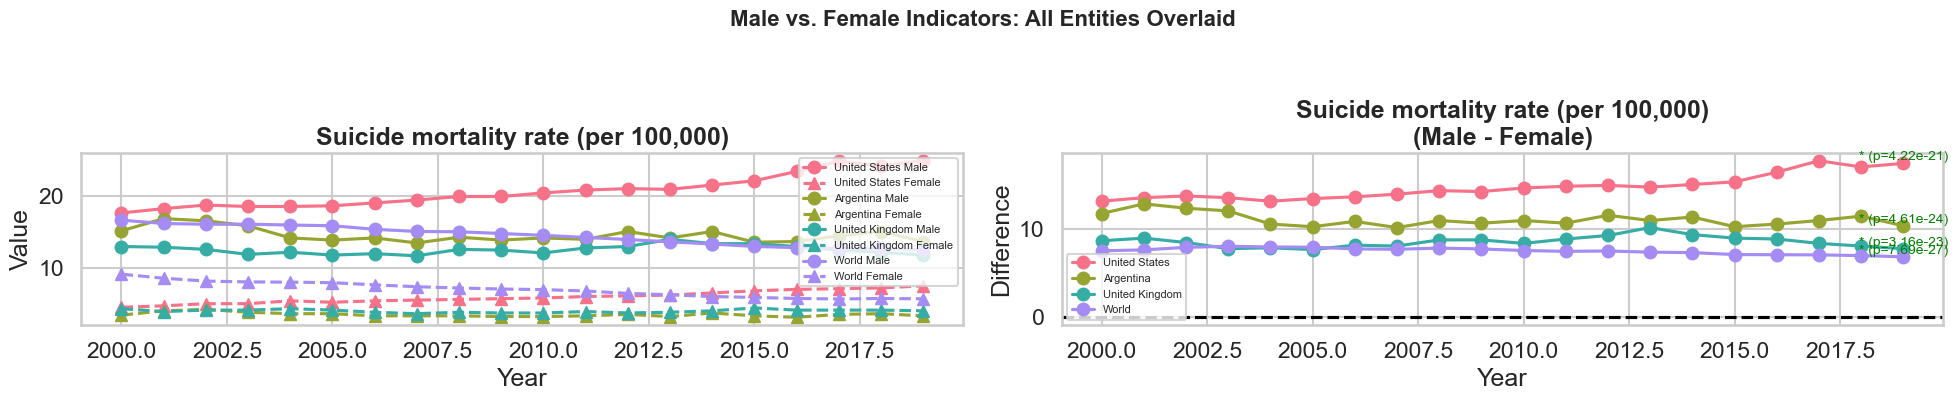

In [1]:
import wbdata
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from requests.exceptions import ConnectionError
from scipy.stats import ttest_rel

sns.set_style('whitegrid')
sns.set_context('talk')


def safe_get_data(indicator, countries, attempts=3, delay=5):
    """
    Safely fetch data from the World Bank API with retries.
    If a ConnectionError occurs, waits `delay` seconds and retries up to `attempts` times.
    """
    for i in range(attempts):
        try:
            data = wbdata.get_data(indicator, country=countries)
            return data
        except ConnectionError:
            print(
                f"Connection error for indicator {indicator}, attempt {i + 1}/{attempts}. Retrying in {delay} seconds...")
            time.sleep(delay)
    print(f"Failed to fetch {indicator} after {attempts} attempts.")
    return []


def process_data(male_data, female_data):
    """
    Process data for male and female indicators, ensuring alignment by date.
    """
    df_m = pd.DataFrame(male_data)
    df_f = pd.DataFrame(female_data)

    df_m['date'] = pd.to_numeric(df_m['date'], errors='coerce')
    df_f['date'] = pd.to_numeric(df_f['date'], errors='coerce')
    df_m = df_m[['date', 'value']].dropna()
    df_f = df_f[['date', 'value']].dropna()

    common_years = set(df_m['date']).intersection(set(df_f['date']))
    if not common_years:
        return None, None

    df_m = df_m[df_m['date'].isin(common_years)].set_index('date').sort_index()
    df_f = df_f[df_f['date'].isin(common_years)].set_index('date').sort_index()

    return df_m['value'], df_f['value']


def plot_indicators(pairs, entities, entity_color_map):
    """
    Plot indicators for male, female, and their differences for multiple entities.
    """
    fig, axes = plt.subplots(len(pairs), 2, figsize=(20, 4 * len(pairs)))
    if len(pairs) == 1:
        axes = [axes]  # Ensure iterable if only one pair
    fig.suptitle("Male vs. Female Indicators: All Entities Overlaid", fontsize=16, fontweight='bold', y=1.02)

    for i, (male_indicator, female_indicator, title) in enumerate(pairs):
        ax_line, ax_diff = axes[i]

        for entity_code, entity_name in entities:
            male_data = safe_get_data(male_indicator, entity_code)
            female_data = safe_get_data(female_indicator, entity_code)

            male_values, female_values = process_data(male_data, female_data)
            if male_values is None or female_values is None:
                continue

            pvalue = ttest_rel(male_values, female_values, nan_policy='omit')[1] if len(male_values) >= 2 else None
            color = entity_color_map[entity_name]

            ax_line.plot(male_values.index, male_values, label=f'{entity_name} Male', color=color, marker='o',
                         linestyle='-')
            ax_line.plot(female_values.index, female_values, label=f'{entity_name} Female', color=color, marker='^',
                         linestyle='--')

            difference = male_values - female_values
            ax_diff.plot(difference.index, difference, color=color, marker='o', label=entity_name)
            if pvalue is not None and pvalue < 0.05:
                ax_diff.text(difference.index[-1], difference.iloc[-1], f"* (p={pvalue:.3g})",
                             fontsize=10, color='green', ha='center', va='bottom')

        _customize_subplot(ax_line, title, xlabel="Year", ylabel="Value")
        _customize_subplot(ax_diff, f"{title}\n(Male - Female)", xlabel="Year", ylabel="Difference", yline=True)

    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()


def _customize_subplot(ax, title, xlabel, ylabel, yline=False):
    """
    Customize plot subplots with title, labels, and grid.
    """
    ax.set_title(title, fontweight='bold')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend(fontsize=8, frameon=True)
    if yline:
        ax.axhline(y=0, color='black', linestyle='--')


# Define pairs
pairs = [
    ("SH.STA.SUIC.MA.P5", "SH.STA.SUIC.FE.P5", "Suicide mortality rate (per 100,000)"),
    # Add more pairs as needed
]

# Entities to plot together:
entities = [
    ("US", "United States"),
    ("AR", "Argentina"),
    ("GB", "United Kingdom"),
    ("WLD", "World")
]

# Assign colors for each entity for consistency
entity_names = [e[1] for e in entities]
palette = sns.color_palette('husl', n_colors=len(entities))
entity_color_map = dict(zip(entity_names, palette))

plot_indicators(pairs, entities, entity_color_map)